Download data

In [4]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2020-11-06 17:00:33--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.34.23, 99.86.34.63, 99.86.34.116, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.34.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2020-11-06 17:00:33 (19.1 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.t

In [5]:
%matplotlib inline


Generating Names with a Character-Level RNN
*******************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In the :doc:`last tutorial </intermediate/char_rnn_classification_tutorial>`
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

I also suggest the previous tutorial, :doc:`/intermediate/char_rnn_classification_tutorial`


Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import math
import random

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Greek', 'Russian', 'Irish', 'Italian', 'Scottish', 'Portuguese', 'Dutch', 'Chinese', 'English', 'Vietnamese', 'Arabic', 'Spanish', 'French', 'Korean', 'Czech', 'Japanese', 'German', 'Polish']
O'Neal


Creating the Network
====================

This network extends `the last tutorial's RNN <#Creating-the-Network>`__
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which `randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:





In [15]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        self.hidden_size = hidden_size
        self.first = True
        self.i2h_1 = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o_1 = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        if self.first:
          input_combined = torch.cat((category, input, hidden), 1)
          hidden = self.i2h_1(input_combined)
          output = self.i2o_1(input_combined)
          self.first = False
        else:
          input_combined = torch.cat(( input, hidden), 1)
          hidden = self.i2h(input_combined)
          output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

class RNN3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN3, self).__init__()
        self.hidden_size = hidden_size
        self.i2h_1 = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o_1 = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.i2h = nn.Linear(n_categories + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat(( category, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


class RNN4(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN4, self).__init__()
        self.hidden_size = hidden_size
        self.first = True
        self.i2h_1 = nn.Linear(n_categories + hidden_size, hidden_size)
        self.i2o_1 = nn.Linear(n_categories + hidden_size, output_size)
        self.i2h = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        if self.first:
          input_combined = torch.cat((category, hidden), 1)
          hidden = self.i2h_1(input_combined)
          output = self.i2o_1(input_combined)
          self.first = False
        else:
          hidden = self.i2h(hidden)
          output = self.i2o(hidden)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [8]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

The category tensor is a `one-hot
tensor <https://en.wikipedia.org/wiki/One-hot>`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [9]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [10]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [20]:
criterion = nn.NLLLoss()

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden_1 = rnn.initHidden()
    hidden_2 = rnn2.initHidden()
    hidden_3 = rnn3.initHidden()
    hidden_4 = rnn4.initHidden()
    

    rnn.zero_grad()
    rnn2.zero_grad()
    rnn3.zero_grad()
    rnn4.zero_grad()


    loss_1 = 0
    loss_2 = 0
    loss_3 = 0
    loss_4 = 0

    for i in range(input_line_tensor.size(0)):
        output_1, hidden_1 = rnn(category_tensor, input_line_tensor[i], hidden_1)
        output_2, hidden_2 = rnn2(category_tensor, input_line_tensor[i], hidden_2)
        output_3, hidden_3 = rnn3(category_tensor, input_line_tensor[i], hidden_3)
        output_4, hidden_4 = rnn4(category_tensor, input_line_tensor[i], hidden_4)
        l_1 = criterion(output_1, target_line_tensor[i])
        l_2 = criterion(output_2, target_line_tensor[i])
        l_3 = criterion(output_3, target_line_tensor[i])
        l_4 = criterion(output_4, target_line_tensor[i])
        loss_1 += l_1
        loss_2 += l_2
        loss_3 += l_3
        loss_4 += l_4

    # compute the gradient by backpropagation
    loss_1.backward()
    loss_2.backward()
    loss_3.backward()
    loss_4.backward()

    # update the parameters
    optimizer_1.step()
    optimizer_2.step()
    optimizer_3.step()
    optimizer_4.step()

    return [(output_1, loss_1.item() / input_line_tensor.size(0)), 
            (output_2, loss_2.item() / input_line_tensor.size(0)),
            (output_3, loss_3.item() / input_line_tensor.size(0)),
            (output_4, loss_4.item() / input_line_tensor.size(0))]

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [12]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [33]:
rnn = RNN(n_letters, 128, n_letters)
optimizer_1 = torch.optim.Adam(rnn.parameters())

rnn2 = RNN2(n_letters, 128, n_letters)
optimizer_2 = torch.optim.Adam(rnn2.parameters())

rnn3 = RNN3(n_letters, 128, n_letters)
optimizer_3 = torch.optim.Adam(rnn3.parameters())

rnn4 = RNN4(n_letters, 128, n_letters)
optimizer_4 = torch.optim.Adam(rnn4.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses_1 = []
all_train_losses_2 = []
all_train_losses_3 = []
all_train_losses_4 = []
all_validation_losses_1 = []
all_validation_losses_2 = []
all_validation_losses_3 = []
all_validation_losses_4 = []
train_loss_1 = 0 # Reset every plot_every iters
train_loss_2 = 0 # Reset every plot_every iters
train_loss_3 = 0 # Reset every plot_every iters
train_loss_4 = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)

    hidden_1 = rnn.initHidden()
    loss_1 = 0

    hidden_2 = rnn2.initHidden()
    loss_2 = 0

    hidden_3 = rnn3.initHidden()
    loss_3 = 0

    hidden_4 = rnn4.initHidden()
    loss_4 = 0
    for i in range(input_line_tensor.size()[0]):
        output_1, hidden_1 = rnn(category_tensor, input_line_tensor[i], hidden_1)
        loss_1 += criterion(output_1, target_line_tensor[i])

        output_2, hidden_2 = rnn2(category_tensor, input_line_tensor[i], hidden_2)
        loss_2 += criterion(output_2, target_line_tensor[i])

        output_3, hidden_3 = rnn3(category_tensor, input_line_tensor[i], hidden_3)
        loss_3 += criterion(output_3, target_line_tensor[i])

        output_4, hidden_4 = rnn4(category_tensor, input_line_tensor[i], hidden_4)
        loss_4 += criterion(output_4, target_line_tensor[i])
    return [(output_1, loss_1.item() / input_line_tensor.size(0)),
            (output_2, loss_2.item() / input_line_tensor.size(0)),
            (output_3, loss_3.item() / input_line_tensor.size(0)),
            (output_4, loss_4.item() / input_line_tensor.size(0))]

def eval_dataset(dataset):
    total_loss_1 = 0
    total_loss_2 = 0
    total_loss_3 = 0
    total_loss_4 = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            outputs = evaluate(category_tensor, input_line_tensor, target_line_tensor)
            output_1, loss_1 = outputs[0]
            output_2, loss_2 = outputs[1]
            output_3, loss_3 = outputs[2]
            output_4, loss_4 = outputs[3]
            total_loss_1 += loss_1
            total_loss_2 += loss_2
            total_loss_3 += loss_3
            total_loss_4 += loss_4

    return [total_loss_1 / n_instances, 
            total_loss_2 / n_instances,
            total_loss_3 / n_instances,
            total_loss_4 / n_instances]

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    outputs = train(*randomTrainingExample())
    output_1, loss_1 = outputs[0]
    output_2, loss_2 = outputs[1]
    output_3, loss_3 = outputs[2]
    output_4, loss_4 = outputs[3]
    
    train_loss_1 += loss_1
    train_loss_2 += loss_2
    train_loss_3 += loss_3
    train_loss_4 += loss_4

    if iter % print_every == 0:
        print('1: %d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_1 / plot_every))
        print('2: %d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_2 / plot_every))
        print('3: %d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_3 / plot_every))
        print('4: %d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_4 / plot_every))

    if iter % plot_every == 0:
        all_train_losses_1.append(train_loss_1 / plot_every)
        all_train_losses_2.append(train_loss_2 / plot_every)
        all_train_losses_3.append(train_loss_3 / plot_every)
        all_train_losses_4.append(train_loss_4 / plot_every)

        train_loss_1 = 0
        train_loss_2 = 0
        train_loss_3 = 0
        train_loss_4 = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        avg_losses = eval_dataset(validation_data)
        average_validation_loss_1 = avg_losses[0]
        average_validation_loss_2 = avg_losses[1]
        average_validation_loss_3 = avg_losses[2]
        average_validation_loss_4 = avg_losses[3]

        # save model with best validation loss
        if len(all_validation_losses_1) == 0 or average_validation_loss_1 < min(all_validation_losses_1):
            torch.save(rnn, 'char_rnn_1_generation_model.pt')
        if len(all_validation_losses_2) == 0 or average_validation_loss_2 < min(all_validation_losses_2):
            torch.save(rnn2, 'char_rnn_2_generation_model.pt')
        if len(all_validation_losses_3) == 0 or average_validation_loss_3 < min(all_validation_losses_3):
            torch.save(rnn3, 'char_rnn_3_generation_model.pt')
        if len(all_validation_losses_4) == 0 or average_validation_loss_4 < min(all_validation_losses_4):
            torch.save(rnn4, 'char_rnn_4_generation_model.pt')
        
        all_validation_losses_1.append(average_validation_loss_1)
        all_validation_losses_2.append(average_validation_loss_2)
        all_validation_losses_3.append(average_validation_loss_3)
        all_validation_losses_4.append(average_validation_loss_4)


Iter 	Train% 	Time 		Train_loss
1: 2500 	6% 	(2m 12s) 	2.4330
2: 2500 	6% 	(2m 12s) 	2.5945
3: 2500 	6% 	(2m 12s) 	2.7333
4: 2500 	6% 	(2m 12s) 	2.9169
1: 5000 	12% 	(4m 48s) 	2.3384
2: 5000 	12% 	(4m 48s) 	2.5092
3: 5000 	12% 	(4m 48s) 	2.6794
4: 5000 	12% 	(4m 48s) 	2.8722
1: 7500 	18% 	(7m 24s) 	2.3439
2: 7500 	18% 	(7m 24s) 	2.4977
3: 7500 	18% 	(7m 24s) 	2.6556
4: 7500 	18% 	(7m 24s) 	2.8369
1: 10000 	25% 	(10m 1s) 	2.2583
2: 10000 	25% 	(10m 1s) 	2.4610
3: 10000 	25% 	(10m 1s) 	2.6235
4: 10000 	25% 	(10m 1s) 	2.8700
1: 12500 	31% 	(12m 42s) 	2.2624
2: 12500 	31% 	(12m 42s) 	2.4881
3: 12500 	31% 	(12m 42s) 	2.6502
4: 12500 	31% 	(12m 42s) 	2.8454
1: 15000 	37% 	(15m 20s) 	2.2423
2: 15000 	37% 	(15m 20s) 	2.4666
3: 15000 	37% 	(15m 20s) 	2.6320
4: 15000 	37% 	(15m 20s) 	2.8287
1: 17500 	43% 	(18m 1s) 	2.2504
2: 17500 	43% 	(18m 1s) 	2.4633
3: 17500 	43% 	(18m 1s) 	2.6069
4: 17500 	43% 	(18m 1s) 	2.8196
1: 20000 	50% 	(20m 46s) 	2.2500
2: 20000 	50% 	(20m 46s) 	2.4549
3: 20000 	50%

Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




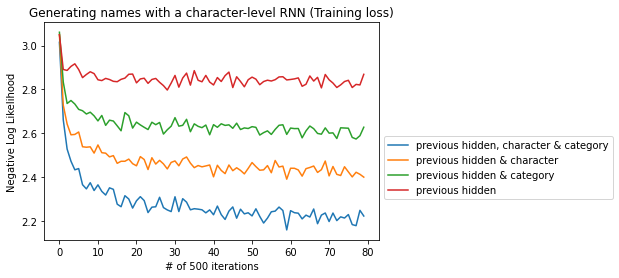

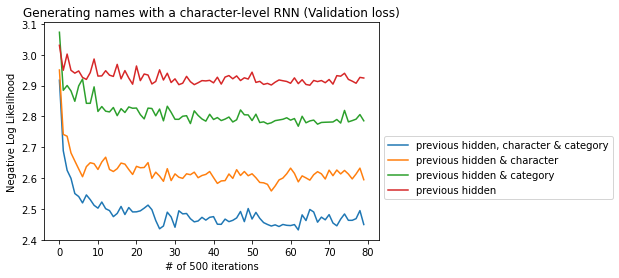

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses_1)
plt.plot(all_train_losses_2)
plt.plot(all_train_losses_3)
plt.plot(all_train_losses_4)

plt.title('Generating names with a character-level RNN (Training loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 500 iterations')
plt.legend(['previous hidden, character & category', 'previous hidden & character', 'previous hidden & category', 'previous hidden'], bbox_to_anchor=(1, 0.5))

plt.figure()
plt.plot(all_validation_losses_1)
plt.plot(all_validation_losses_2)
plt.plot(all_validation_losses_3)
plt.plot(all_validation_losses_4)
plt.title('Generating names with a character-level RNN (Validation loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 500 iterations')
plt.legend(['previous hidden, character & category', 'previous hidden & character', 'previous hidden & category', 'previous hidden'], bbox_to_anchor=(1, 0.5))



In [42]:
# evaluate on test set and print average test loss
rnn = torch.load('char_rnn_1_generation_model.pt')
rnn2 = torch.load('char_rnn_2_generation_model.pt')
rnn3 = torch.load('char_rnn_3_generation_model.pt')
rnn4 = torch.load('char_rnn_4_generation_model.pt')
average_test_loss = eval_dataset(test_data)
avgloss_1 = average_test_loss[0]
avgloss_2 = average_test_loss[1]
avgloss_3 = average_test_loss[2]
avgloss_4 = average_test_loss[3]
print('Previous hidden, character & category Average test loss: ' + str(avgloss_1))
print('Previous hidden & character Average test loss: ' + str(avgloss_2))
print('Previous hidden & category Average test loss: ' + str(avgloss_3))
print('Previous hidden Average test loss: ' + str(avgloss_4))

Previous hidden, character & category Average test loss: 2.4387644415812137
Previous hidden & character Average test loss: 2.564704026783709
Previous hidden & category Average test loss: 2.77032918087749
Previous hidden Average test loss: 2.9027318554953103


# Explanation

Using previous hidden unit, character and category has the lowest average loss in training, validation and testing. The second lowest average loss is obtained using previous hidden unit and characters. The third lowest average loss is obtained using previous hidden unit and category. Using just the previous hidden unit has the highest average loss. 


One observation is that there is a larger difference in loss between using previous hidden unit and characters with using previous hidden unit and categories. This shows that previous character is an important information to pass into the hidden unit at each step. Having previous characters can help the RNN generate sequences better.

Using just the previous hidden unit results in the highest loss, this shows that categories input also plays an important role in the decoder performance, although not as important as characters.

Finally, using hidden unit, character and category results in the lowest average loss in training. All three information are important in helping the RNN generate sequences. 

